In [1]:
import multiA as ma
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from Node import BranchingProgram
from Node import Node
import scipy.io
import time

In [2]:
# these are the cells used in the branching program to bucket points based on their importance weights. The width of
# the program is 2*L. It's probably not informative/necessary to change this parameter too much

L = 30
n_cells = np.zeros(2*L)
n_cells[L] = 1
lam = 1.3
for i in np.arange(1,L):
    n_cells[L + i] = n_cells[L+i-1] * lam
    n_cells[L - i] = n_cells[L - i + 1] / lam
print(n_cells)

[0.00000000e+00 4.96184031e-04 6.45039240e-04 8.38551013e-04
 1.09011632e-03 1.41715121e-03 1.84229657e-03 2.39498555e-03
 3.11348121e-03 4.04752557e-03 5.26178325e-03 6.84031822e-03
 8.89241369e-03 1.15601378e-02 1.50281791e-02 1.95366329e-02
 2.53976227e-02 3.30169096e-02 4.29219824e-02 5.57985771e-02
 7.25381503e-02 9.42995954e-02 1.22589474e-01 1.59366316e-01
 2.07176211e-01 2.69329074e-01 3.50127797e-01 4.55166136e-01
 5.91715976e-01 7.69230769e-01 1.00000000e+00 1.30000000e+00
 1.69000000e+00 2.19700000e+00 2.85610000e+00 3.71293000e+00
 4.82680900e+00 6.27485170e+00 8.15730721e+00 1.06044994e+01
 1.37858492e+01 1.79216039e+01 2.32980851e+01 3.02875107e+01
 3.93737639e+01 5.11858930e+01 6.65416609e+01 8.65041592e+01
 1.12455407e+02 1.46192029e+02 1.90049638e+02 2.47064529e+02
 3.21183888e+02 4.17539054e+02 5.42800770e+02 7.05641001e+02
 9.17333302e+02 1.19253329e+03 1.55029328e+03 2.01538126e+03]


In [3]:
## setting the parameters for the mixture of Gaussians

d = 2
delta = 2.5*np.ones(d)
k = 15

sigma = np.eye(d)
means_p = np.random.multivariate_normal(np.zeros(d), k*10000*sigma, k)
means_r = means_p + delta

In [4]:
## finding pairwise distances between centers to ensure Gaussians are far away

dist = 100*np.ones((k,k))
for i in range(k):
    for j in np.arange(i+1,k):
        dist[i,j] = np.linalg.norm(means_p[i,:]-means_p[j,:])
        
np.min(dist)

60.663500493935956

In [5]:
def normal_kl(mu0,mu1,cov0,cov1):
    cov1inv = np.linalg.inv(cov1)
    det1 = np.linalg.det(cov1)
    det0 = np.linalg.det(cov0)
    x = np.trace(np.matmul(cov1inv,cov0)) + np.matmul(np.matmul(np.transpose(mu1 - mu0),cov1inv), (mu1-mu0)) - len(mu0) + np.log(det1/det0)
    x = x/(2*np.log(2))
    return x

In [6]:
kl_approx = normal_kl(means_r[1,:],means_p[1,:],sigma,sigma) 
print(kl_approx)

9.016844005556022


In [7]:
## finding pairwise KL-divergences between centers to ensure Gaussians are far away

kl_approx = 10000*np.ones((k,k))
for i in range(k):
    for j in np.arange(i+1,k):
        kl_approx[i,j] = normal_kl(means_r[i,:],means_p[j,:],sigma,sigma) 

kl_approx.min()

2894.8426195205893

In [8]:
## function to return samples from p and r

def return_p_sample(N, k, means_p, sigma):
    per_comp = int(N/k)
    data_p = np.random.multivariate_normal(means_p[0,:], sigma, per_comp)
    for i in np.arange(1,k):
        add_data = np.random.multivariate_normal(means_p[i,:], sigma, per_comp)
        data_p = np.concatenate((data_p,add_data), axis = 0)
    data_p = np.random.permutation(data_p)
    return data_p

def return_r_sample(N, k, means_r, sigma):
    per_comp = int(N/k)
    data_r = np.random.multivariate_normal(means_r[0,:], sigma, per_comp)
    for i in np.arange(1,k):
        add_data = np.random.multivariate_normal(means_r[i,:], sigma, per_comp)
        data_r = np.concatenate((data_r,add_data), axis = 0)
    data_r = np.random.permutation(data_r)
    return data_r

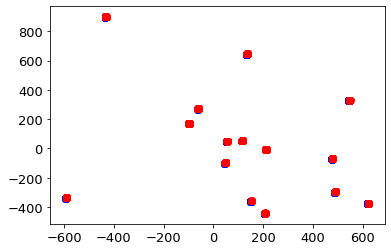

In [10]:
## plotting the data

N = 30000
data_p = return_p_sample(N, k, means_p, sigma)
data_r = return_r_sample(N, k, means_r, sigma)

plt.scatter(data_p[:,0],data_p[:,1],color='b')
plt.scatter(data_r[:,0],data_r[:,1],color='r')
plt.rcParams.update({'font.size': 13})

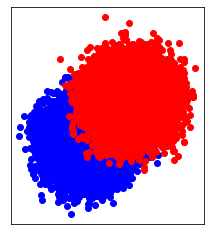

In [11]:
## plotting a single pair of Gaussians

index = 0
data_p = np.random.multivariate_normal(means_p[index,:], sigma, N)
data_r = np.random.multivariate_normal(means_r[index,:], sigma, N)

plt.scatter(data_p[:,0],data_p[:,1],color='b')
plt.scatter(data_r[:,0],data_r[:,1],color='r')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_aspect('equal')

In [12]:
N = 30000
data_p = return_p_sample(N, k, means_p, sigma)
data_r = return_r_sample(N, k, means_r, sigma)

In [13]:
## running the branching program, with the classifier given by the classifier function

def classifier():
    return RandomForestClassifier(max_depth=5, n_estimators=10)
#     return LogisticRegression()

A = BranchingProgram(n_cells, 25, 0.02, classifier, reweigh = 0)
A.fit(data_p,data_r)
A.compute_kl()

total r,p is  15000 15000
Seems distributions have different support. Computing only for common support
adding  0.7226734576314854  to the kl
adding  0.8784316808863551  to the kl
adding  1.0443779500330281  to the kl
adding  0.691759048734946  to the kl
adding  0.6094941387494386  to the kl
adding  0.48135041164791376  to the kl
adding  0.23668504256727177  to the kl
adding  0.0661928190176486  to the kl
adding  0.1536  to the kl
adding  0.08228083034057083  to the kl
adding  0.021144875274320938  to the kl
adding  0.02888834752394061  to the kl
adding  0.03591396576305559  to the kl
adding  0.039178062522574414  to the kl
adding  0.014884569121205202  to the kl
adding  0.00684207276911109  to the kl
adding  0.0  to the kl
adding  -0.00295322924801006  to the kl
adding  -0.010988412006242575  to the kl
adding  -0.001341036917835067  to the kl
adding  -0.011326090844894318  to the kl
adding  -0.004734226176985945  to the kl
adding  -0.0042176602454347045  to the kl
adding  -0.008266526

5.004512975714289

In [14]:
## predicting the KL between the distributions on a fresh test sample

N = 30000
data_p = return_p_sample(N, k, means_p, sigma)
data_r = return_r_sample(N, k, means_r, sigma)

A.predict_kl_pair(data_p, data_r)

adding  1.0656669350699381  to the kl
adding  0.558407202211582  to the kl
adding  0.9045624917422169  to the kl
adding  1.1330338131529145  to the kl
adding  0.7410139078744793  to the kl
adding  0.6594821861937514  to the kl
adding  0.48796492446766637  to the kl
adding  0.23460424373451064  to the kl
adding  0.05394692333497574  to the kl
adding  0.15038431958445142  to the kl
adding  0.07703260078362574  to the kl
adding  0.02279377004883068  to the kl
adding  0.024742992356493063  to the kl
adding  0.04997435389486697  to the kl
adding  0.04211104751150935  to the kl
adding  0.013592943980897087  to the kl
adding  0.010514765262750563  to the kl
adding  0.0004470282307949415  to the kl
adding  -0.00378958092957353  to the kl
adding  -0.012357425238186948  to the kl
adding  -0.0014121821727688202  to the kl
adding  -0.010523252508385608  to the kl
adding  -0.005068105933460741  to the kl
adding  -0.004593747820702974  to the kl
adding  -0.008084682100878888  to the kl
adding  -0.00

6.121430664772773

In [29]:
## predicting the KL between the distributions on each subpopulation given by a pair of Gaussians

mc_subgroup = np.zeros(k)
for i in range(k):
    per_comp = 100000
    data_p = np.random.multivariate_normal(means_p[i,:], sigma, per_comp)
    data_r = np.random.multivariate_normal(means_r[i,:], sigma, per_comp)
    mc_subgroup[i] = A.predict_kl_pair(data_p, data_r)

adding  2.769910076956123  to the kl
adding  3.0255684822601503  to the kl
adding  0.0025356315236980047  to the kl
adding  0.27426142558518674  to the kl
adding  0.3797819922585444  to the kl
adding  0.39090027751594086  to the kl
adding  0.23667051998138985  to the kl
adding  0.013336151302710198  to the kl
adding  0.02093310885930802  to the kl
adding  0.06150968016333308  to the kl
adding  0.019268868908048645  to the kl
adding  0.0010329837312990928  to the kl
adding  0.0033158044907396814  to the kl
adding  -0.004871280201203319  to the kl
adding  -0.012090404832895233  to the kl
adding  -0.0041977982837624345  to the kl
adding  -0.007629194833505202  to the kl
adding  -0.01421310464555743  to the kl
adding  -0.013344417550928732  to the kl
adding  -0.037743478873181295  to the kl
adding  -0.017650870149082384  to the kl
adding  4.672460675941794  to the kl
adding  1.1437057939289255  to the kl
adding  0.6643531226688482  to the kl
adding  0.0199094421112412  to the kl
adding  0.

adding  4.479313225151887  to the kl
adding  1.2823792039026567  to the kl
adding  0.029976228752761864  to the kl
adding  0.23400948356341497  to the kl
adding  0.04260573247151124  to the kl
adding  0.17885823691872174  to the kl
adding  0.004003471933750399  to the kl
adding  0.13564680978930482  to the kl
adding  0.03533514998675607  to the kl
adding  0.013863570112487105  to the kl
adding  0.001989641614591117  to the kl
adding  -0.004058704557189649  to the kl
adding  0.003539691595353251  to the kl
adding  -0.003832926407499248  to the kl
adding  -0.001553235879675129  to the kl
adding  -0.013601020217199547  to the kl
adding  -0.014269947908002983  to the kl
adding  -0.008296182293973645  to the kl
adding  -0.009167583051493854  to the kl
adding  -0.007143765077036694  to the kl
adding  -0.041627199442213686  to the kl
adding  3.121593440232437  to the kl
adding  2.3610887203262565  to the kl
adding  0.7718835008532706  to the kl
adding  0.5588592459378883  to the kl
adding  0.

In [30]:
for i in range(k):
    print(mc_subgroup[i])

7.087284454166356
6.785606526041893
6.980982445810617
6.6130519186065335
6.013365810128464
5.994097369125939
7.2042169242529965
6.587837966167507
6.412782338068152
6.1436680403256
6.33796988095891
6.89260388421233
5.726689127506367
5.223022984202944
6.161810208711241


In [17]:
## running the multiaccuracy (MaxEnt/LL-KLIEP) program, with the classifier given by the classifier function

def classifier():
    return RandomForestClassifier(max_depth=10, n_estimators=20)
#     return RandomForestClassifier(max_depth=5, n_estimators=10)

N = 30000
data_p = return_p_sample(N, k, means_p, sigma)
data_r = return_r_sample(N, k, means_r, sigma)

me = ma.MaxEnt()
me.fit(data_p, data_r, iter=1000, clr_maker=classifier, eps=0.02, eta=0.02)

iteration  0
advantage:  0.5884
updating weights
iteration  1
advantage:  0.6362802596679921
updating weights
iteration  2
advantage:  0.6381219372060981
updating weights
iteration  3
advantage:  0.6417221412536268
updating weights
iteration  4
advantage:  0.6335321215876086
updating weights
iteration  5
advantage:  0.626163266131257
updating weights
iteration  6
advantage:  0.6263006595214818
updating weights
iteration  7
advantage:  0.6385989305229494
updating weights
iteration  8
advantage:  0.6406170910582608
updating weights
iteration  9
advantage:  0.6381959842250846
updating weights
iteration  10
advantage:  0.6620244689881086
updating weights
iteration  11
advantage:  0.6259356126870699
updating weights
iteration  12
advantage:  0.579399371263569
updating weights
iteration  13
advantage:  0.5727060187313906
updating weights
iteration  14
advantage:  0.5662073733531237
updating weights
iteration  15
advantage:  0.5515601748545232
updating weights
iteration  16
advantage:  0.6300

advantage:  0.5101628251981202
updating weights
iteration  133
advantage:  0.44336175566100167
updating weights
iteration  134
advantage:  0.43058055930866096
updating weights
iteration  135
advantage:  0.44847774550392094
updating weights
iteration  136
advantage:  0.4272956269133059
updating weights
iteration  137
advantage:  0.4911821420292284
updating weights
iteration  138
advantage:  0.43915003927930013
updating weights
iteration  139
advantage:  0.4424029024262464
updating weights
iteration  140
advantage:  0.3740836038566674
updating weights
iteration  141
advantage:  0.46601219593823157
updating weights
iteration  142
advantage:  0.3868990357048439
updating weights
iteration  143
advantage:  0.41518803343662897
updating weights
iteration  144
advantage:  0.493284628885203
updating weights
iteration  145
advantage:  0.4666673308806469
updating weights
iteration  146
advantage:  0.43622190470214695
updating weights
iteration  147
advantage:  0.4179960638080218
updating weights
i

advantage:  0.2238731360015327
updating weights
iteration  263
advantage:  0.20921757355252812
updating weights
iteration  264
advantage:  0.2005873533574586
updating weights
iteration  265
advantage:  0.19852801276934412
updating weights
iteration  266
advantage:  0.1469205112371229
updating weights
iteration  267
advantage:  0.21775613850666692
updating weights
iteration  268
advantage:  0.1899261820211352
updating weights
iteration  269
advantage:  0.39218624797473967
updating weights
iteration  270
advantage:  0.1632360134636846
updating weights
iteration  271
advantage:  0.25458576987516457
updating weights
iteration  272
advantage:  0.17385196230499617
updating weights
iteration  273
advantage:  0.08034129357273734
updating weights
iteration  274
advantage:  0.1756349791573668
updating weights
iteration  275
advantage:  0.1143463786621795
updating weights
iteration  276
advantage:  0.07637580936728539
updating weights
iteration  277
advantage:  0.2253936376590215
updating weights

In [18]:
## predicting the KL between the distributions on a fresh test sample

N = 30000
data_p = return_p_sample(N, k, means_p, sigma)
data_r = return_r_sample(N, k, means_r, sigma)

me.compute_KL(data_r)

3.330052173144226

In [33]:
## predicting the KL between the distributions on each subpopulation given by a pair of Gaussians

me_subgroup = np.zeros(k)
for i in range(k):
    print(i)
    per_comp = 100000
    data_r = np.random.multivariate_normal(means_r[i,:], sigma, per_comp)
    me_subgroup[i] = me.compute_KL(data_r)

In [34]:
for i in range(k):
    print(mc_subgroup[i], me_subgroup[i])

7.087284454166356 5.076502519166573
6.785606526041893 5.251538072080442
6.980982445810617 4.989308916285326
6.6130519186065335 5.813086919015897
6.013365810128464 5.693159719812913
5.994097369125939 0.6392951175359398
7.2042169242529965 3.989709957460626
6.587837966167507 5.262496206533018
6.412782338068152 -1.0582107412478867
6.1436680403256 -0.323777111165519
6.33796988095891 5.744078198586047
6.89260388421233 -0.9384018430382546
5.726689127506367 4.228577552458627
5.223022984202944 5.7449259261920735
6.161810208711241 -0.34780981369565556


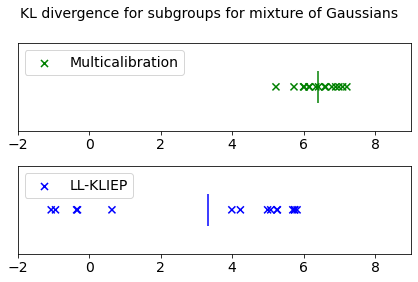

In [35]:
fig, axs = plt.subplots(2)

plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize
plt.rc('figure', titlesize=14)  # fontsize of the figure title

k = 15
fig.suptitle('KL divergence for subgroups for mixture of Gaussians')
axs[0].scatter(mc_subgroup,np.zeros(k),color='g', marker = 'x', s = 50*np.ones(k))
axs[0].scatter(np.mean(mc_subgroup),0,color='g', marker = '|', s = 1000*np.ones(1))
axs[0].set_xlim([-2, 9])
axs[0].axes.get_yaxis().set_visible(False)
axs[0].legend(['Multicalibration'],loc='upper left')
axs[1].scatter(me_subgroup,np.zeros(k),color='b', marker = 'x', s = 50*np.ones(k))
axs[1].scatter(np.mean(me_subgroup),0,color='b', marker = '|', s = 1000*np.ones(1))
axs[1].set_xlim([-2, 9])
axs[1].axes.get_yaxis().set_visible(False)
axs[1].legend(['LL-KLIEP'],loc='upper left')
fig.tight_layout() 

In [36]:
print(np.std(mc_subgroup), np.std(me_subgroup))

0.5295402252110115 2.7015130286862292


Text(0.5, 0.98, 'Contour plots for Multiaccuracy/LL-KLIEP')

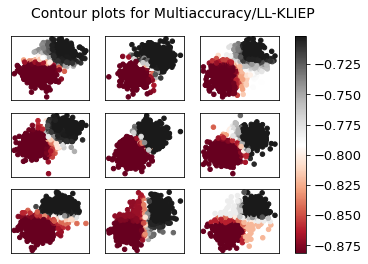

In [37]:
## contour plots for Multiaccuracy

fig, ax = plt.subplots(3, 3)

for i in range(9):

    N = 500
    index = i
    data_p = np.random.multivariate_normal(means_p[index,:], sigma, N)
    data_r = np.random.multivariate_normal(means_r[index,:], sigma, N)

    data_grid = np.concatenate((data_p,data_r), axis = 0)
    weights = me.compute_weight(data_grid)
    ii = np.mod(i,3)
    jj = int(i/3)
    pcm = ax[ii,jj].scatter(data_grid[:,0], data_grid[:,1], c=np.log(weights), cmap='RdGy',s=20)
    ax[ii,jj].axes.get_xaxis().set_visible(False)
    ax[ii,jj].axes.get_yaxis().set_visible(False)

fig.colorbar(pcm, ax=ax[:, :], shrink=1)
fig.suptitle('Contour plots for Multiaccuracy/LL-KLIEP')

0


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


1
2


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


3


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


4


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log


5
6
7
8


Text(0.5, 0.98, 'Contour plots for Multicalibration')

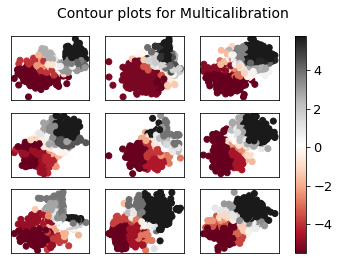

In [38]:
N = 500
mc_wt = np.zeros((2*N,9))
save_data = []

fig, ax = plt.subplots(3, 3)

for i in range(9):

    print(i)
    index = i
    data_p = np.random.multivariate_normal(means_p[index,:], sigma, N)
    data_r = np.random.multivariate_normal(means_r[index,:], sigma, N)

    data_grid = np.concatenate((data_p,data_r), axis = 0)
    L = len(data_grid)
    for ii in range(len(data_grid)):
        mc_wt[ii,i] = A.get_weight(data_grid[ii,:])

    save_data.append(data_grid)
    
    ii = np.mod(i,3)
    jj = int(i/3)
    pcm = ax[ii,jj].scatter(data_grid[:,0], data_grid[:,1], c=-np.log(mc_wt[:,i]), cmap='RdGy')
    ax[ii,jj].axes.get_xaxis().set_visible(False)
    ax[ii,jj].axes.get_yaxis().set_visible(False)

fig.colorbar(pcm, ax=ax[:, :], shrink=1)
fig.suptitle('Contour plots for Multicalibration')